# Effect of Forcings on CAMELs Simulations

Now we can look at the output and see if there are any patterns across the variables or across basin characteristics.

First we load the imports.

Populating the interactive namespace from numpy and matplotlib


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
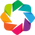

In [1]:
%pylab inline
import cartopy
import geoviews as gv
import geopandas as gpd
import holoviews as hv
import pandas as pd
import xarray as xr
#import seaborn as sns
import ogr
from scipy import stats

pylab.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 96
hv.notebook_extension('bokeh')

<br>
Load the shapefiles.

In [2]:
top = '/glade/work/ashleyvb'
folder = top+'/CAMELs'
folders = folder+'/summa_camels'

In [3]:
shapefile = folder+'/basin_set_full_res_simple/HCDN_nhru_final_671.shp'
gdf = gpd.read_file(shapefile)

<br>

# Summary Statistics of Error on output
Let's look at some error metrics by HRU.
KGE means perfect agreement if it is 1, and <0 means the mean is a better guess. 
Bias means perfect aggreement if it is 0, and larger means larger error. 
All errors have 1's added so we dont' divide by 0. 

In [4]:
# truth data set
sim_truth = xr.open_dataset(folders+'/output/merged_day/NLDAS_1hr_hru.nc')

In [5]:
# Set forcings to hold at constant or MetSim and create dictionaries
cm_vars= ['all','airpres','airtemp','LWRadAtm','pptrate','spechum','SWRadAtm','windspd']
error_kind = ['bias','kge']
est_kind = ['constant','metsim']
seas_kind = ['YEAR','DJF','MAM','JJA','SON']
#forcing, liquid water fluxes for the soil domain, turbulent heat transfer, snow, vegetation, derived 
var_sim=['airpres','airtemp','LWRadAtm','pptrate','spechum','SWRadAtm','windspd',
          'scalarSurfaceRunoff','scalarAquiferBaseflow','scalarInfiltration','scalarRainPlusMelt','scalarSoilDrainage',
          'scalarLatHeatTotal','scalarSenHeatTotal','scalarSnowSublimation',
          'scalarSWE',
          'scalarCanopyWat',
          'scalarNetRadiation','scalarTotalET','scalarTotalRunoff','scalarTotalSoilWat']

In [6]:
# definitions for KGE computation
def covariance(x,y,dims=None):
    return xr.dot(x-x.mean(dims), y-y.mean(dims), dims=dims) / x.count(dims)

def correlation(x,y,dims=None):
    return covariance(x,y,dims) / (x.std(dims) * y.std(dims))

In [7]:
# set up xarray
hrud = sim_truth['hru']
shape = (len(hrud), len(cm_vars),len(est_kind), len(error_kind),len(seas_kind))
dims = ('hru','var','estimation','error','season')
coords = {'hru': hrud, 'var':cm_vars, 'estimation':est_kind, 'error':error_kind, 'season':seas_kind}
error_data = xr.Dataset(coords=coords)
for s in var_sim:
    error_data[s] = xr.DataArray(data=np.full(shape, np.nan),
                                 coords=coords, dims=dims,
                                 name=s)

In [8]:
%%time
#This takes ~35 min 
truth0 = sim_truth #.drop('hruId').load()
for v in cm_vars:
    for c in est_kind:     
        sim0 = xr.open_dataset(folders+'/output/merged_day/NLDAS' + c + '_' + v +'_hru.nc')
        sim0 = sim0 #.drop('hruId').load()
        for i, t in enumerate(seas_kind):     
            if i==0: 
                truth = truth0
                sim = sim0
            if i>0: 
                truth = truth0.sel(time=truth0['time.season']==t)
                sim = sim0.sel(time=sim0['time.season']==t)
                
            r = sim.mean(dim='time') #to set up xarray since xr.dot not supported on dataset and have to do loop
            for s in var_sim:         
                r[s] = correlation(sim[s],truth[s],dims='time')
            # KGE value for each hru, add 1 so no nan
            ds = 1 - np.sqrt( np.square(r-1) 
                + np.square( (sim.std(dim='time')+1)/(truth.std(dim='time')+1) - 1) 
                + np.square( (sim.mean(dim='time')+1)/(truth.mean(dim='time')+1) - 1) )
            ds0 = ds.load()
            # bias value for each hru, add 1 so no nan
            ds = np.abs(sim-truth)/(truth+1) 
            ds1 = ds.mean(dim='time').load()
            for s in var_sim:
                error_data[s].loc[:,v,c,'kge',t]  = ds0[s]
                error_data[s].loc[:,v,c,'bias',t] = ds1[s]
    print(v)

# keep hruId incase want later
#error_data['hruId'] = sim_truth['hruId']

all
airpres
airtemp
LWRadAtm
pptrate
spechum
SWRadAtm
windspd
CPU times: user 25min 39s, sys: 9min 10s, total: 34min 49s
Wall time: 35min 11s


In [9]:
#error_data.to_netcdf(folder+'/regress_data/error_data.nc') #save this because it hangs up a lot

<br>
KGE does not need to be normalized. We plot the HRU error as stack of values, with no error plotting as a height of 1 for that color. Values less than 0 are plotted as 0. 

In [8]:
error_data =  xr.open_dataset(folder+'/regress_data/error_data.nc') #read this because it hangs up a lot

In [80]:
# Setup plots
x = np.arange(len(hrud))
col_vars = ['gray','y','r','g','orange','c','m','b']
letter = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
wid = ceil(len(var_sim)/3)
inc = floor(len(hrud)/10)
if inc<1: inc=1
xtic = np.arange(1, len(hrud)+.05,inc).tolist()
xtic =[int(i) for i in xtic]
xtics =[str(i) for i in xtic]
labels =["V"+i for i in xtics]

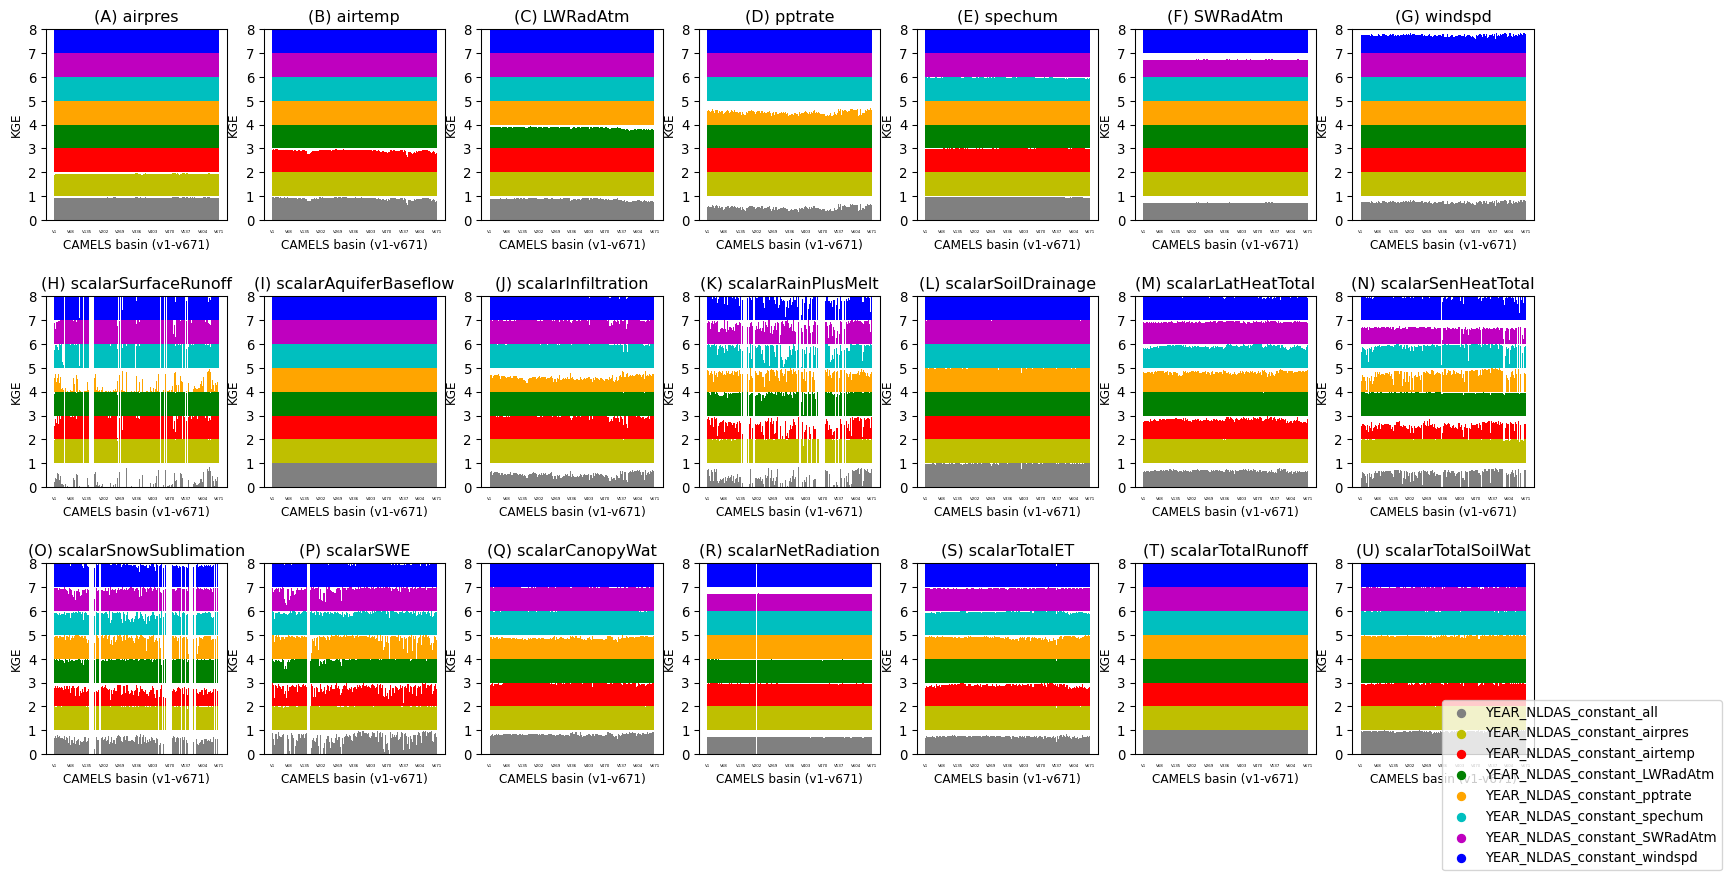

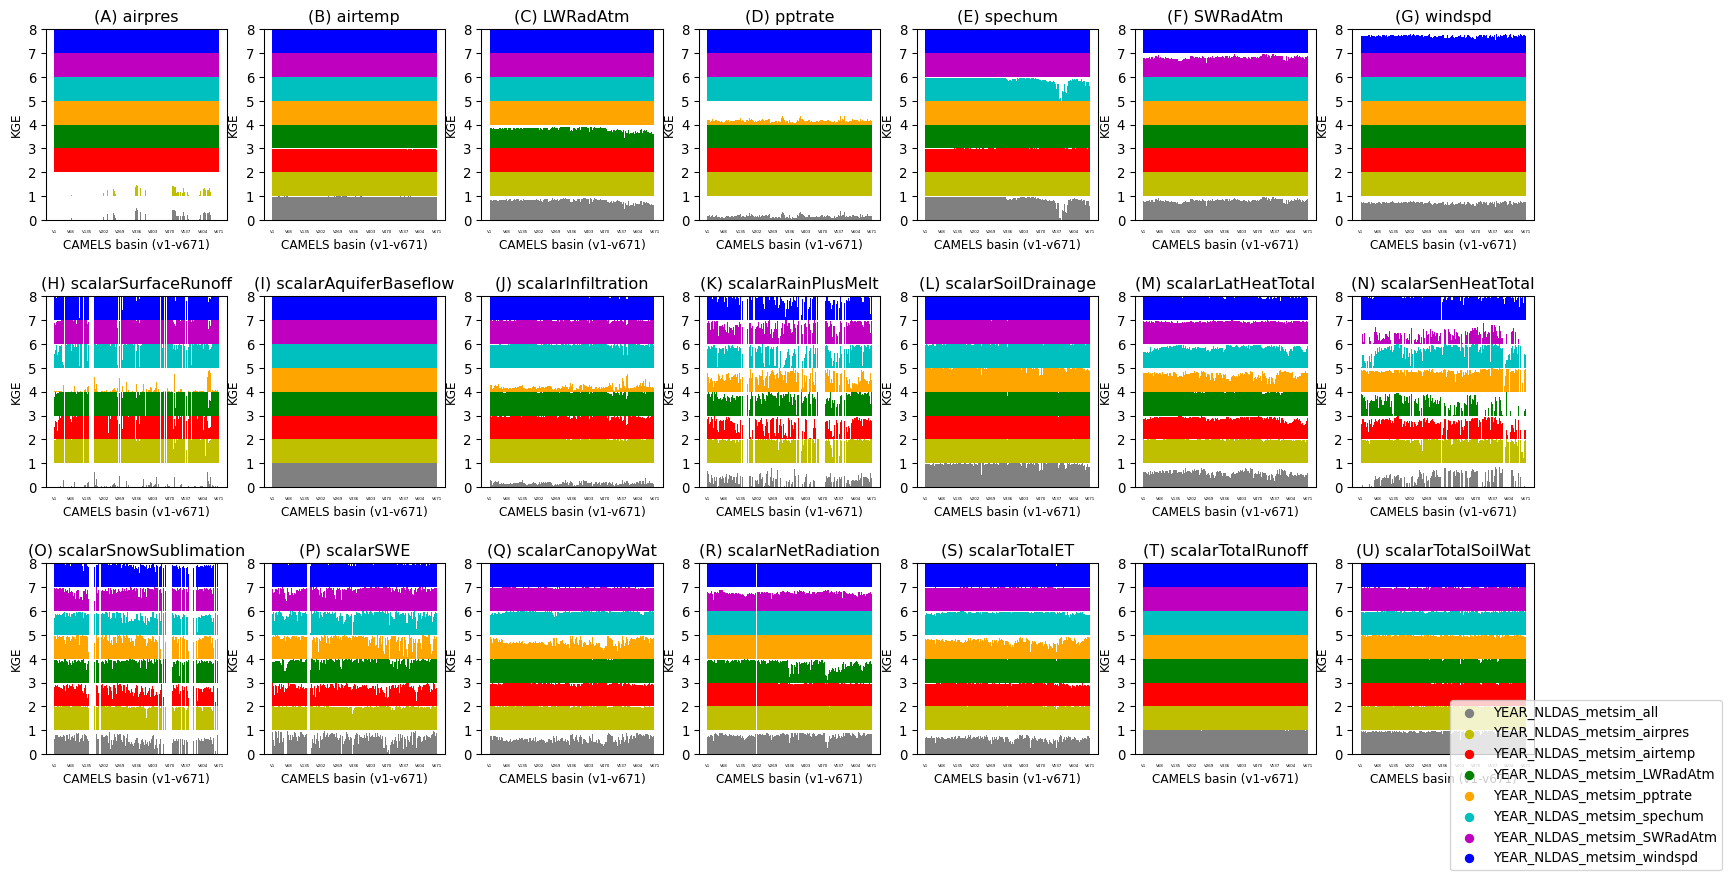

CPU times: user 7min 51s, sys: 1.32 s, total: 7min 52s
Wall time: 7min 51s


In [91]:
%%time
# Just plot all-- takes 8 min. Maybe add winter, and summer if you want to see more detail. 
ind = [0]#,1,3]
seas_kind0 = [ seas_kind[i] for i in ind]
for c in est_kind:      
    for t in seas_kind0:     
        plot1 = plt.figure(1, figsize = (20,10))

        for i, s in enumerate(var_sim):
            data0 = error_data[s].loc[:,:,c,'kge',t]
            data = data0.where(data0>0,0) #make the negative values be 0
            data_Master = [0] * len(hrud)
    
            plot2 = plt.subplot(3,wid,i+1)
            for j, v in enumerate(cm_vars):
                plt.bar(height = data.loc[:,v], x = x, width = 1.0, color = col_vars[j], bottom = data_Master)
                #data_Master = [m + n for m, n in zip(data_Master, data.loc[:,v])]
                data_Master = [j+1] * len(hrud)
         
            plt.title('('+letter[i]+') '+s)
            plt.ylim(0,len(cm_vars))
            plt.xticks(xtic, labels, fontsize = 3)
            plt.yticks(np.arange(0, len(cm_vars)+.05, 1).tolist())
            plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
            plt.xlabel("CAMELS basin (v1-v671)", fontsize = 9)
            plt.ylabel("KGE", fontsize = 9)

        plt.subplots_adjust(hspace = .4)

        for j, v in enumerate(cm_vars):
            plt.scatter([],[], color = col_vars[j], label = t + '_NLDAS_' + c + '_' + v)
        plt.figlegend(loc = 'lower right')
        plt.show()

<br>
We see that the pptrate and air pressure would be better off constant than at MetSim values (thiner orange and yellow layers in the MetSim plots), but that the air pressure does not matter in the variable calculation (except simulation of air pressure itself). Air temperature has less error in MetSim. 
By season, there is more error in the winter in both Metsim and Constant.

<br>

# Correlations of Error and Basin Attributes
We look at the basin attributes to see if there are any patterns with the error sizes. 
We use the Kendall non-parametric correlation based on ranks, so that error magnitude (that is likely more affected by calibrated or not calibrated parameters) is not a factor. 
The attribute file that SUMMA uses does not have many continuous variables in it, so we use the raw attribute data that would have been used to derive the SUMMA attribute file. 
TEST Budyko of each setup??

In [92]:
# Here is the file used by SUMMA. It does not have many values and a bunch of them are indices.  
attrib0 = xr.open_dataset(folders+'/settings.v1/attributes.camels.v2.nc')
print(attrib0)

<xarray.Dataset>
Dimensions:         (gru: 671, hru: 671)
Dimensions without coordinates: gru, hru
Data variables:
    hru2gruId       (hru) int32 ...
    downHRUindex    (hru) int32 ...
    hruId           (hru) int32 ...
    contourLength   (hru) float32 ...
    mHeight         (hru) float64 ...
    slopeTypeIndex  (hru) float64 ...
    soilTypeIndex   (hru) float64 ...
    tan_slope       (hru) float64 ...
    vegTypeIndex    (hru) float64 ...
    elevation       (hru) float64 ...
    longitude       (hru) float64 ...
    latitude        (hru) float64 ...
    HRUarea         (hru) float64 ...
    gruId           (gru) int32 ...
Attributes:
    history:                    Tue Dec 31 11:39:11 2019: ncks -A gruId.nc lo...
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    history_of_appended_files:  Tue Dec 31 11:39:11 2019: Appended file gruId...


In [10]:
# And here are the attribute data
# variables to regress, take only floats
lr_attrib0 = attrib0.get(['hruId']) 
file_name = ['clim','geol','hydro','soil','topo','vege']
n_attrib = file_name
for i, f in enumerate(file_name):
    df = pd.read_csv(folder+'/regress_data/camels_'+f+'.txt',delimiter=';')
    df['hru'] = range(0,671)
    xr_tmp = df.set_index(['hru']).to_xarray()
    xr_att = xr_tmp.drop([ var for var in xr_tmp.variables if not 'float64'==xr_tmp[var].dtype ])
    if i==0: n_attrib[i]= len(xr_att.variables)-1
    if i>0: n_attrib[i]= len(xr_att.variables)+n_attrib[i-1]
    lr_attrib0 =xr.merge([lr_attrib0,xr_att])
lr_attrib = lr_attrib0.drop('hruId').load()
attrib_kind = list(lr_attrib.variables.keys())
print(n_attrib)
print(lr_attrib)

[8, 13, 26, 37, 43, 51]
<xarray.Dataset>
Dimensions:               (hru: 671)
Dimensions without coordinates: hru
Data variables:
    p_mean                (hru) float64 3.127 3.608 3.274 ... 6.297 2.782 5.556
    pet_mean              (hru) float64 1.972 2.119 2.044 ... 2.435 3.325 2.28
    p_seasonality         (hru) float64 0.1879 -0.1145 ... -0.9855 -1.016
    frac_snow             (hru) float64 0.3134 0.2453 0.277 ... 0.1415 0.02433
    aridity               (hru) float64 0.6306 0.5874 0.6241 ... 1.195 0.4103
    high_prec_freq        (hru) float64 12.95 20.55 17.15 ... 14.6 20.45 19.3
    high_prec_dur         (hru) float64 1.349 1.205 1.208 ... 1.467 1.786 1.538
    low_prec_freq         (hru) float64 202.2 233.7 215.6 ... 219.1 260.4 237.0
    low_prec_dur          (hru) float64 3.427 3.662 3.514 ... 6.241 7.355 6.91
    glim_1st_class_frac   (hru) float64 0.8159 0.5907 0.5733 ... 0.9835 0.6062
    glim_2nd_class_frac   (hru) float64 0.1797 0.1646 0.287 ... 0.01652 0.289
    ca

<br>
Now run the regressions and plot. 

In [93]:
# set up xarray
attrib_num = ['clim','geol','hydro','soil','topo','vege']
shape = (len(attrib_kind), len(cm_vars),len(est_kind), len(error_kind),len(seas_kind))
dims = ('attrib','var','estimation','error','season')
coords = {'attrib': attrib_kind, 'var':cm_vars, 'estimation':est_kind, 'error':error_kind, 'season':seas_kind}
corr_data = xr.Dataset(coords=coords)
for s in var_sim:
    corr_data[s] = xr.DataArray(data=np.full(shape, np.nan),
                                 coords=coords, dims=dims,
                                 name=s)

In [94]:
def r_cor(x,y, pthres = 0.01, direction = False):
    """
    Uses the scipy stats module to calculate a Kendall correlation test
    :pthres: Significance of the underlying test
    :direction: output only direction as output (-1 & 1)
    """
    
    # Check NA values
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    if len(x[~nas]) < 10: # If fewer than 10 data return nan
        return np.nan
    if norm(x[~nas] - mean(x[~nas])) < 1e-13 * abs(mean(x[~nas])): #near constant attibute
         return np.nan
    if norm(y[~nas] - mean(y[~nas])) < 1e-13 * abs(mean(y[~nas])): #near constant error
         return np.nan
       
    
    # Run the kendalltau test
    #stat, p_value = stats.kendalltau(x[~nas], y[~nas])
    # Run the spearmanr test
    #stat, p_value = stats.spearmanr(x[~nas], y[~nas])
    # Run the pearsonr test
    stat, p_value = stats.pearsonr(x[~nas], y[~nas])
    
    # Criterium to return results in case of Significance
    if p_value < pthres:
        # Check direction
        if direction:
            if stat < 0:
                return -1
            elif stat > 0:
                return 1
        else:
            return stat
    else:
      return 0  

# The function we are going to use for applying our kendall test
def rank_correlation(x,y):
    return xr.apply_ufunc(
        r_cor, x , y
        )

In [95]:
%%time
#This takes ~7  min 
for a in attrib_kind:
    ds0 = lr_attrib[a]
    for v in cm_vars:
        for c in est_kind:
            for k in error_kind:
                for t in seas_kind:
                    for s in var_sim:
                        ds1 = error_data[s].loc[:,v,c,k,t]
                        value = rank_correlation(ds0.values, ds1.values)
                        corr_data[s].loc[a,v,c,k,t] = value

/glade/work/ashleyvb/miniconda3/envs/pysumma/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


CPU times: user 6min 21s, sys: 16.7 s, total: 6min 38s
Wall time: 6min 38s


In [96]:
# Setup plots
x = np.arange(len(attrib_kind))
col_vars = ['gray','y','r','g','orange','c','m','b']
letter = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
wid = ceil(len(var_sim)/3)
xtic = n_attrib
labels =file_name

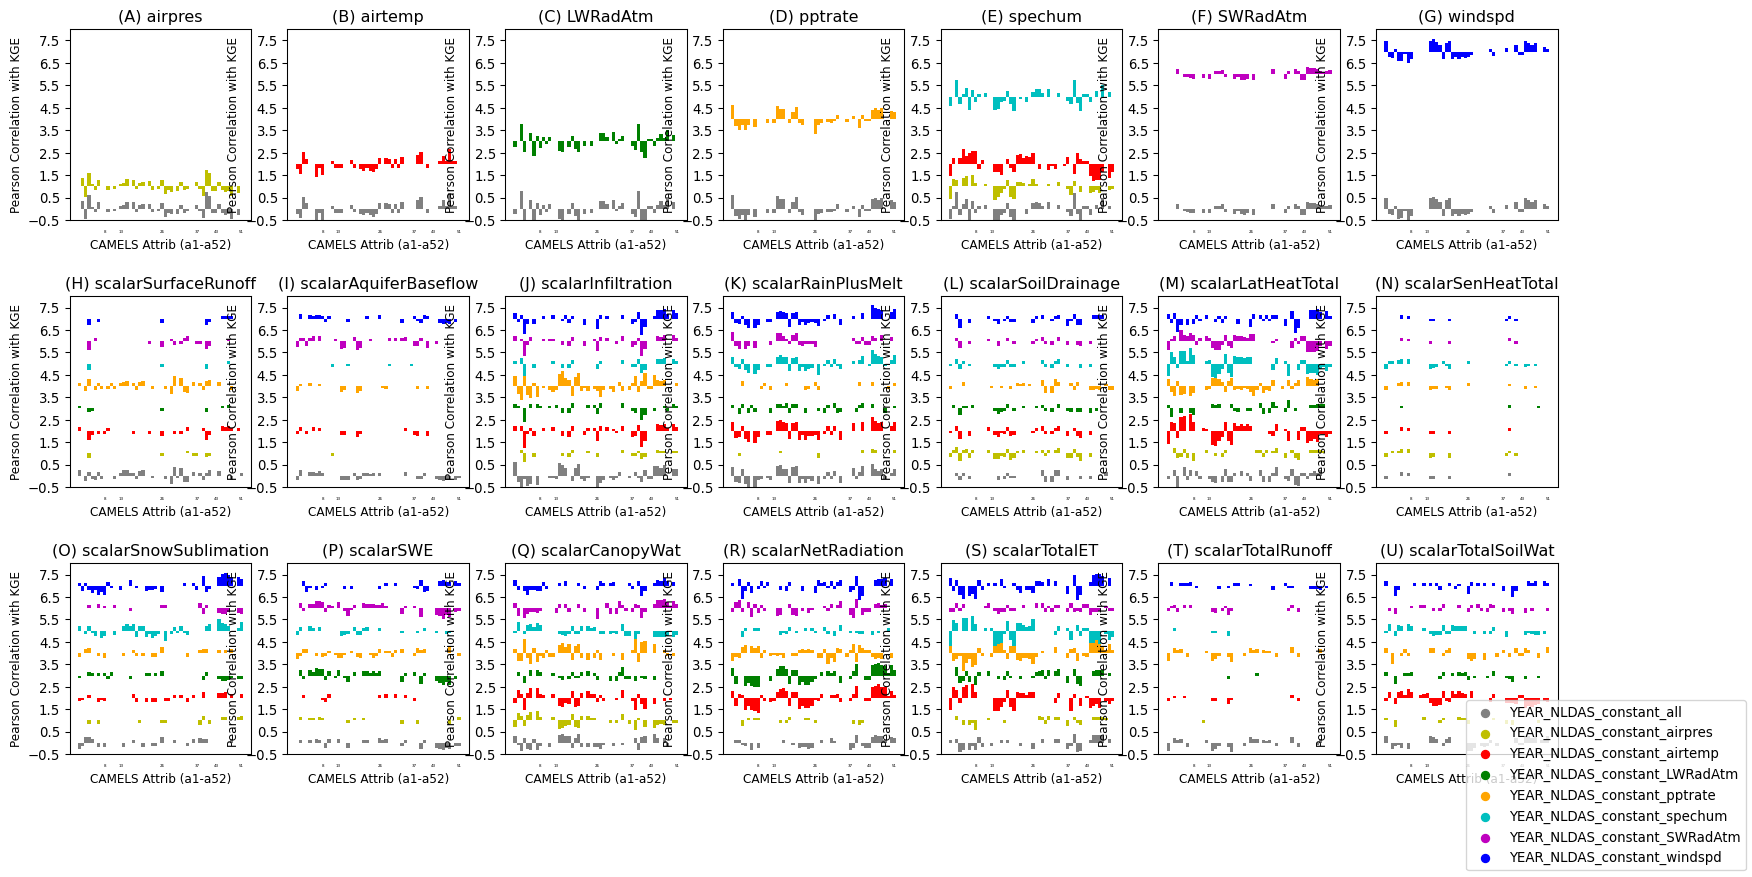

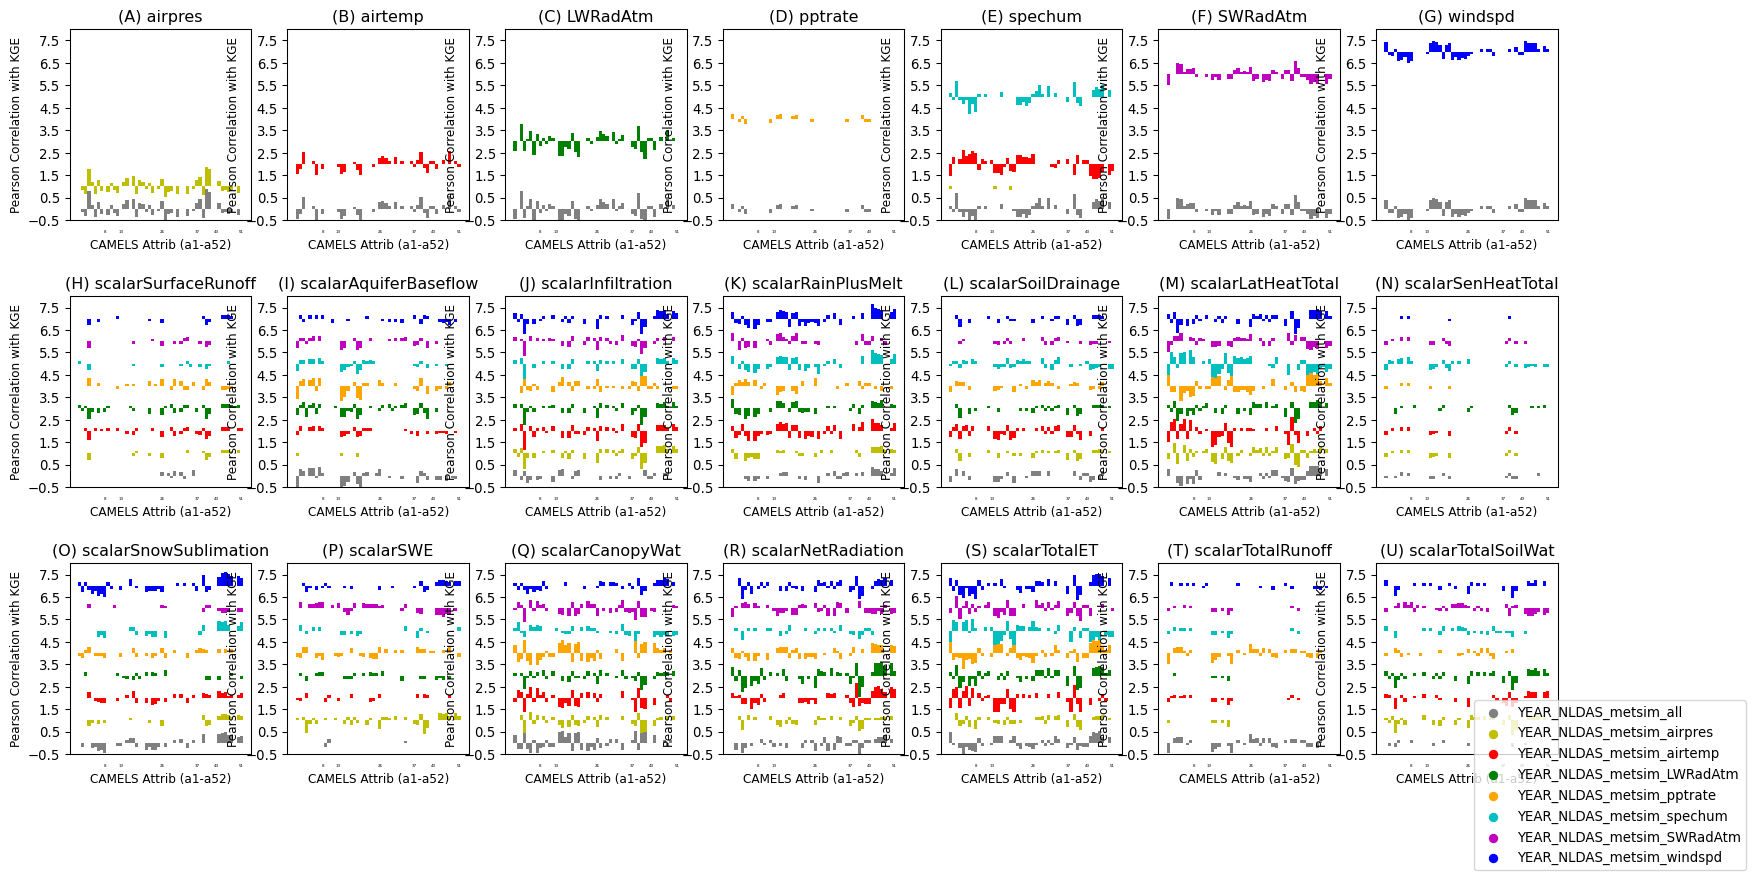

CPU times: user 48.4 s, sys: 104 ms, total: 48.5 s
Wall time: 48.4 s


In [98]:
%%time
# Just plot all, winter, and summer for simplicity. 
ind = [0] #,1,3]
seas_kind0 = [ seas_kind[i] for i in ind]
for c in est_kind:      
    for t in seas_kind0:     
        plot1 = plt.figure(1, figsize = (20,10))

        for i, s in enumerate(var_sim):
            data0 = corr_data[s].loc[:,:,c,'kge',t]
            #data = abs(data0)
            data = data0
            data_Master = [0] * len(attrib_kind)
    
            plot2 = plt.subplot(3,wid,i+1)
            for j, v in enumerate(cm_vars):
                plt.bar(height = data.loc[:,v], x = x, width = 1.0, color = col_vars[j], bottom = data_Master)
                #data_Master = [m + n for m, n in zip(data_Master, data.loc[:,v])]
                data_Master = [j+1] * len(attrib_kind)
        
            plt.title('('+letter[i]+') '+s)
            plt.xticks(xtic, labels, fontsize = 3)
            #plt.ylim(0,(len(cm_vars)/1.8))
            #plt.yticks(np.arange(0, (len(cm_vars)/2.0)+.55, 0.5).tolist())
            plt.ylim(0,len(cm_vars))
            plt.yticks(np.arange(-0.5, len(cm_vars)+.05, 1).tolist())
            plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
            plt.xlabel("CAMELS Attrib (a1-a52)", fontsize = 9)
            plt.ylabel("Pearson Correlation with KGE", fontsize = 9)

        plt.subplots_adjust(hspace = .4)

        for j, v in enumerate(cm_vars):
            plt.scatter([],[], color = col_vars[j], label = t + '_NLDAS_' + c + '_' + v)
        plt.figlegend(loc = 'lower right')
        plt.show()